# Sliding Window Localizer
We opted against using a panorama approach. Instead, we compare the robot's latest images against 72 images gathered in the initial phase. Given a potential pose, this compare the recent image to the one of the 72 images closes to that pose. Instead of comparing these images directly, we pretend as if the images aren't perfectly aligned and thus compare several cropped offset versions of each image to the latest image.

## Imports
We use the following packages in our implementation.
- `numpy` arrays allow us to compare the images and get the mean squared error
- `cv2` allows us to read in images from files
- `math` provides important constants and functions for our error calculations
- `random` allows random particle generation
- `cozmo` allows us to communicate with the robot. `cozmo.util` helps us to tell the robot some umber of degrees
- `matplotlib.pyplot` is used to show the current beliefs of the robot in a histogram
- `os` is used for joining file paths
- `sys` gives us an integer maxsize as our starting point when looking at differences between images

In [1]:
import numpy as np
import cv2
import math
import random
import cozmo
from cozmo.util import degrees
import matplotlib.pyplot as plt
from PIL import Image as im 
import os
import sys


This parameter is related to the same parameter in `ImageGathering.ipynb` corresponding to how poses should be rounded to the nearest image

In [2]:
degree_increment = 5

These define the locations of the images taken in `ImageGathering.ipynb` for reference.

In [3]:
parent_dir = r"C:\Users\Dressler\Pictures"
path = os.path.join(parent_dir, "resized0")

Compares two images, retrieving the mean square error (MSE)

In [4]:
def compare_images(imageA, imageB):
  # See https://en.wikipedia.org/wiki/Mean_squared_error 
  dimensions = imageA.astype('float').shape
  width = dimensions[1]
  height = dimensions[0]
  err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
  # Dividing the values so they fit 
  err /= (width * height * width * height)
  return err

These define our measurement and movement model, which help the robot to update its beliefs on further iterations.

In [5]:
sensorVariance = 0.05
proportionalMotionVariance = 0.01

def measurement_model0(particlePose):
  # Get the source image (from initial rotation) to compare to by rounding to the nearest multiple
  # of degree_increment
  roundedPose = int(degree_increment * round(float(particlePose) / degree_increment)) % 360
  # Fetch the source image from this position
  source_image_path = os.path.join(path, 'image' + str(roundedPose) + ".jpeg")
  # Read in the source image and the latest
  source_image = cv2.imread(source_image_path)
  latest_image = cv2.imread('latestImage.jpeg')

  minDiff = sys.maxsize
  # Sliding window:
  # We initialize the difference as the max possible ...
  height, width = source_image.shape[0:2]
  source_half_height = source_image.shape[0] // 3
  latest_half_height = latest_image.shape[0] // 3
  # Each offset represents a different sliding image pair 
  for offset in range(90, 10, -10):
    # crop the images, getting the overlapping portions
    overlap = width - offset
    source_cropped = source_image[0:source_half_height, 0:overlap]
    latest_cropped = latest_image[0:latest_half_height, offset:width]
    # compare the cropped images
    diff = compare_images(source_cropped, latest_cropped)
    # update minDiff. We assume that the least image difference should be used for each of these
    # according to the fact that even slightly offset images may report large differences
    # even if they are very similar
    minDiff = min(minDiff, diff)
  
  # reverse the roles of the images for cases where the latest image spills over the right hand
  # side of the source image
  for offset in range(10, 90, 10):
    overlap = width - offset
    source_cropped = source_image[0:source_half_height, 0:overlap]
    latest_cropped = latest_image[0:latest_half_height, offset:width]
    diff = compare_images(source_cropped, latest_cropped)
    minDiff = min(minDiff, diff)

  # the least difference should be used for the differences of these two images
  diff = minDiff
  #see Text Table 5.2, implementation of probability normal distribution
  return (1.0 / math.sqrt(2 * math.pi * sensorVariance)) * math.exp(- (diff * diff) / (2 * sensorVariance))




In [6]:
sensorVariance = 0.05
proportionalMotionVariance = 0.01

def measurement_model(particlePose):
  # Get the source image (from initial rotation) to compare to by rounding to the nearest multiple
  # of degree_increment
  roundedPose = int(degree_increment * round(float(particlePose) / degree_increment)) % 360
  # Fetch the source image from this position
  source_image_path = os.path.join(path, 'image' + str(roundedPose) + ".jpeg")
  # Read in the source image and the latest
  source_image = cv2.imread(source_image_path)
  latest_image = cv2.imread('latestImage.jpeg')

  minDiff = sys.maxsize
  # Sliding window:
  # We initialize the difference as the max possible ...
  height, width = source_image.shape[0:2]
  # Each offset represents a different sliding image pair 
  for offset in range(90, 10, -10):
    # crop the images, getting the overlapping portions
    overlap = width - offset
    source_cropped = source_image[0:height, 0:overlap]
    latest_cropped = latest_image[0:height, offset:width]
    # compare the cropped images
    diff = compare_images(source_cropped, latest_cropped)
    # update minDiff. We assume that the least image difference should be used for each of these
    # according to the fact that even slightly offset images may report large differences
    # even if they are very similar
    minDiff = min(minDiff, diff)
  
  # reverse the roles of the images for cases where the latest image spills over the right hand
  # side of the source image
  for offset in range(10, 90, 10):
    overlap = width - offset
    source_cropped = source_image[0:height, offset:width]
    latest_cropped = latest_image[0:height, 0:overlap]
    diff = compare_images(source_cropped, latest_cropped)
    minDiff = min(minDiff, diff)

  # the least difference should be used for the differences of these two images
  diff = minDiff
  #see Text Table 5.2, implementation of probability normal distribution
  return (1.0 / math.sqrt(2 * math.pi * sensorVariance)) * math.exp(- (diff * diff) / (2 * sensorVariance))
def motion_model(movement, current_position):
  # making variance proportional to magnitude of motion command
  newDeg = current_position - movement - sample_normal_distribution(abs(movement * proportionalMotionVariance)) 
  # apply modulus to make sure the newX wraps around when it passes over either edge of the panorama
  return newDeg % 360
def sample_normal_distribution(variance):
  sum = 0
  for i in range(12):
    sum += (2.0 * random.random()) - 1.0
  return math.sqrt(variance) * sum / 2.0

In [7]:
def resizeCozmoImage (image_name, width, height):
    
    image = cv2.imread(image_name)
    
    res = cv2.resize(image, dsize=(width, height), interpolation=cv2.INTER_LINEAR)
    
    rImg = im.fromarray(res)
    rImg.save("latestImage.jpeg", "JPEG", resolution=10)

## Actual localization
In this function, we generate 150 random particles representing different degrees of rotation. We then evolve the population by updating our beliefs through the measurement and movement models such that future generations include more likely candidates for positions. Our loop runs until any 20 degree increment includes 40% of the total probability of it member particles.

In [8]:
def localize(robot: cozmo.robot.Robot):
    robot.say_text("localizing").wait_for_completed()
    robot.camera.image_stream_enabled = True

    # generate a (random) initial population of M possible positions
    M = 150
    particles = [] 
    for i in range(M):
        particles.append(random.randint(0, 360))

    poses_and_weights = None

    # iterate until any given 20 degree bin contains 40% of the robot's belief likelihood.
    max_prob_bin = 0
    est_position = None
    while max_prob_bin < 0.5:
        # take pictures in 10 degree increments
        robot.turn_in_place(degrees(-10.0)).wait_for_completed()
        latest_image = robot.world.latest_image
        while latest_image is None:
            latest_image = robot.world.latest_image
        rImg = latest_image.raw_image
        if latest_image is not None:
            #converted = annotated.convert()
            rImg.save("temp.jpeg", "JPEG", resolution=10)
            #TODO: globalize these variables
            resizeCozmoImage ("temp.jpeg", 270, 180)
    
        # Initialize arrays to store poses, corresponding weights, and their normalized probabilities
        poses_and_weights = np.empty([M, 3])
        newPosition = None
        # for each potential position
        for p in range(M):
            currentPosition = particles[p]
            # update our belief about where the given pose represents, given the movement just made
            newPosition = motion_model(degree_increment, currentPosition)
            # Assign a weight to this position based on the image difference
            weight = measurement_model(newPosition) 
            # store this information
            poses_and_weights[p] = [newPosition, weight, 0]

        # normalize the relative likelihoods
        total_weight = 0.0
        for p in range(M):
            total_weight += poses_and_weights[p, 1]
        # store the normalized probabilities
        for p in range(M): 
            poses_and_weights[p,2] = poses_and_weights[p, 1] / total_weight
        # make CDF
        sum = 0
        cdf = []
        for p in range(M):
            sum += poses_and_weights[p,2]
            cdf.append(sum)
        cdf[M-1] = 1.0

        # Resample, according to this CDF
        newParticles = []
        for p in range(M):
            p = random.random()
            index = 0
            while p >= cdf[index]:
                index += 1
            newParticles.append(poses_and_weights[index,0])
        # Specify the new population of positions for the next iteration
        particles = newParticles

        # visualize the robot's beliefs about it's current position
        fig, ax = plt.subplots(figsize=(10, 7))
        ax.hist(np.array(newParticles))
        plt.show()
        # Sum up the belief probabilities, in 20 degree increments
        bin_width = 20
        prob_bins = [0 for i in range(0, 360, bin_width)]
        for (pose, weight, prob) in poses_and_weights:
            prob_bins[int(pose // bin_width)] += prob
        # Print an estimated positoin
        if max_prob_bin != 0:
            est_position = prob_bins.index(max(prob_bins)) * bin_width
            print(f'est: {est_position}')
        print(f'The 20 degree bin with the higher probability has a probability of {max(prob_bins)}')
        # update the probability in the max bin so the robot can continue
        # if it is still unsure
        max_prob_bin = max(prob_bins)
    
    # based on the position the robot thinks it is in, rotate back to home
    robot.turn_in_place(degrees(-est_position)).wait_for_completed()
    robot.say_text("I'm hooooooooome!").wait_for_completed()

Random turning just for testing purposes

In [9]:
#def rand_turn(robot: cozmo.robot.Robot):
#    robot.turn_in_place(degrees(-random.randint(0, 360))).wait_for_completed()
#cozmo.run_program(rand_turn)

Alternatively, the following file waits for the user to press enter, which allows for a manual random rotation.

In [10]:
input("Press enter after randomly rotating the robot...")

''

c:\Users\Dressler\AppData\Local\Programs\Python\Python39\lib\site-packages\cozmo\event.py:488: DeprecationWarning: The loop argument is deprecated since Python 3.8, and scheduled for removal in Python 3.10.
  return await asyncio.wait_for(f, timeout, loop=self._loop)
2024-04-30 22:45:41,055 cozmo.general INFO     App connection established. sdk_version=1.4.10 cozmoclad_version=3.4.0 app_build_version=00003.00004.00000
2024-04-30 22:45:41,060 cozmo.general INFO     Found robot id=1
2024-04-30 22:45:41,077 cozmo.general INFO     Connected to Android device serial=1A071FDF600FFW
2024-04-30 22:45:41,340 cozmo.general INFO     Robot id=1 serial=4322be95 initialized OK


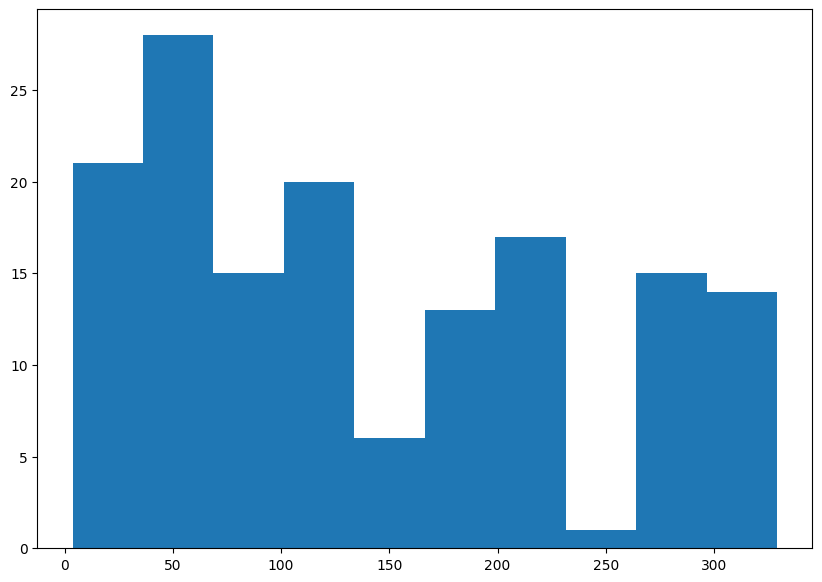

The 20 degree bin with the higher probability has a probability of 0.14068227890002719


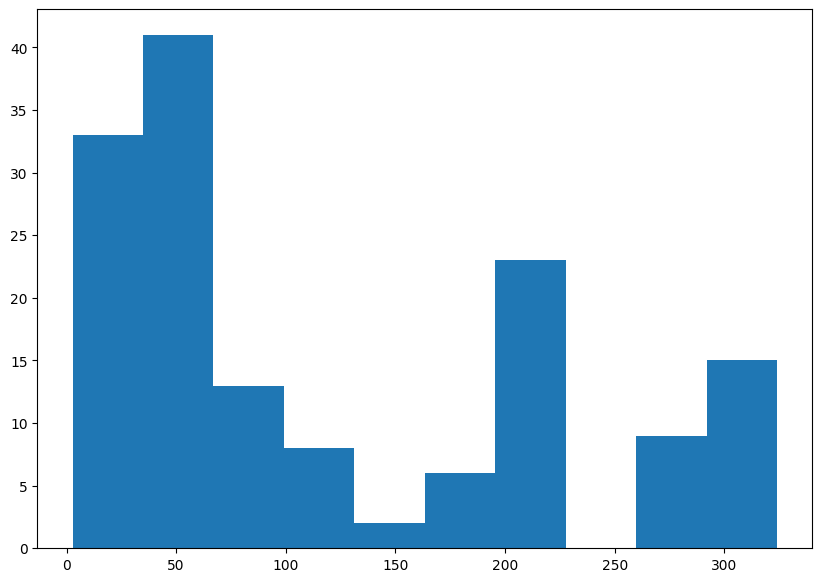

est: 40
The 20 degree bin with the higher probability has a probability of 0.22841163919333413


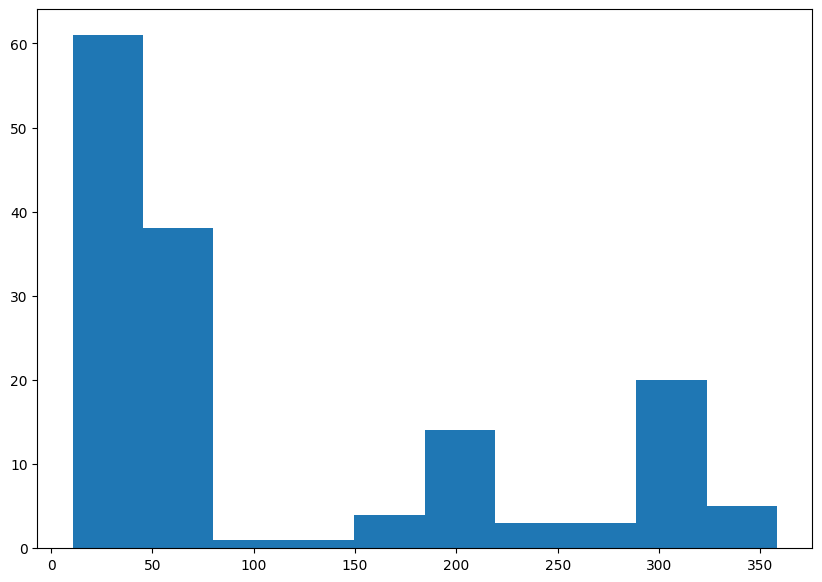

est: 20
The 20 degree bin with the higher probability has a probability of 0.24058499685710458


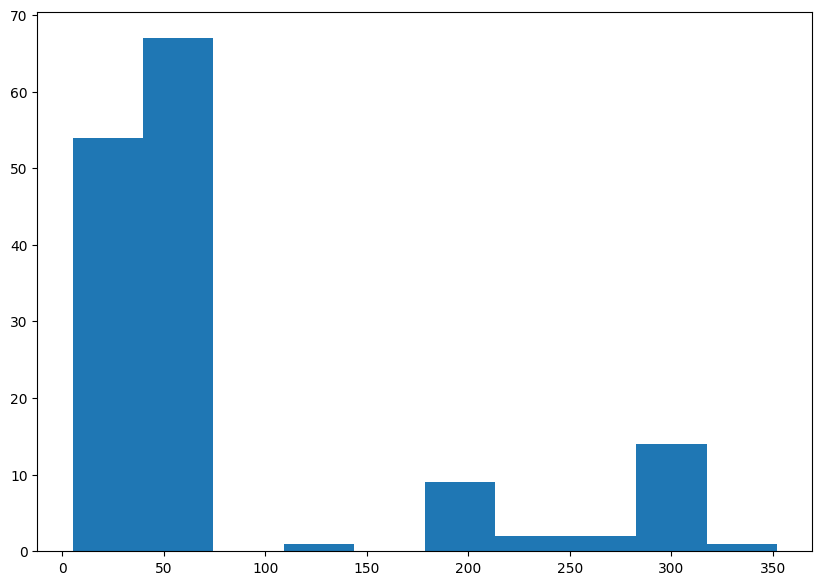

est: 0
The 20 degree bin with the higher probability has a probability of 0.22194632822131855


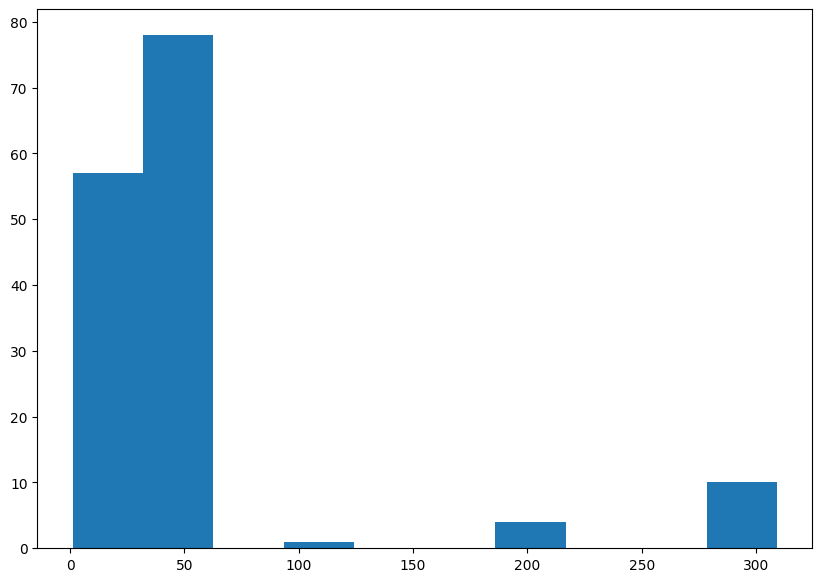

est: 20
The 20 degree bin with the higher probability has a probability of 0.4319371998452349


2024-04-30 22:46:41,377 cozmo.general INFO     Shutting down connection
2024-04-30 22:46:41,380 cozmo.general INFO     Android serial=1A071FDF600FFW disconnected.


In [11]:
cozmo.run_program(localize)